# Fisher Information Analysis and Model Cross-Fitting

Code used to run analysis and generate plots for "Mitigating effects of jitter through differentiable
forwards-modeling for the TOLIMAN space telescope".

In [1]:
import os

import jax
from jax import numpy as np, random as jr, Array
import zodiax as zdx
import dLux as dl
import dLuxToliman as dlT

# Enable 64bit precision (note this must be run in the first cell of the notebook)
jax.config.update("jax_enable_x64", True)

import optax
from tqdm.notebook import tqdm
import random
from datetime import datetime

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import scienceplots
import cmasher as cmr

plt.style.use(["science", "no-latex"])
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 300

# Colour schemes
ito_seven = [
    "#0072B2",
    "#D55E00",
    "#009E73",
    "#CC79A7",
    "#56B4E9",
    "#E69F00",
    "#F0E442",
]
contrast_three = ["#004488", "#BB5566", "#DDAA33"]

In [2]:
# Set to True if you want to run the computation
# Set to False if you want to load the pre-calculated results from disk
run_compute = False

Setting up the model.

In [3]:
from setup_jitter import setup_jitter

models, datas, params, loglike_fns, cov_fns = setup_jitter(
    oversample=4,
    n_psfs=5,
)

2025-03-28 09:42:26.857998: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng2{k2=1,k3=0} for conv (f64[1,1,1024,1024]{3,2,1,0}, u8[0]{0}) custom-call(f64[1,1,1024,1024]{3,2,1,0}, f64[1,1,17,17]{3,2,1,0}), window={size=17x17 pad=8_8x8_8}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-03-28 09:42:29.220601: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.362711105s
Trying algorithm eng2{k2=1,k3=0} for conv (f64[1,1,1024,1024]{3,2,1,0}, u8[0]{0}) custom-call(f64[1,1,1024,1024]{3,2,1,0}, f64[1,1,17,17]{3,2,1,0}), window={size=17x17 pad=8_8x8_8}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activat

## Linear & SHM Models: FIA

The Fisher Information analysis for the Linear and SHM jitter models, and their respective plots.

In [4]:
def fisher_sweep(
    tel,
    cov_fn,
    params,
    mags=np.linspace(1e-4, 2 * 0.375, 10),
    angs=np.linspace(0, 90, 3),
):

    seps = []

    # looping over jitter magnitude
    for mag_idx, mag in tqdm(enumerate(mags), total=len(mags)):
        model = tel.set("jitter_mag", mag)

        # looping over jitter angle
        for ang_idx, ang in enumerate(angs):
            model = model.set("jitter_angle", ang)
            data = model.jitter_model()

            # calculate covariance matrix
            cov = cov_fn(model, np.round(data), params)

            # read separation from covariance matrix
            sep = np.sqrt(np.abs(cov[0, 0]))
            seps.append(sep)

            # check for NaNs
            if np.isnan(sep).any():
                print(f"NaNs found at mag_idx={mag_idx}, ang_idx={ang_idx}")
                raise ValueError

    seps = np.array(seps).reshape(len(mags), len(angs))
    return seps

In [5]:
# Marginal parameters
params = [
    "separation",
    "position_angle",
    "x_position",
    "y_position",
    "log_flux",
    "contrast",
    "jitter_mag",
    "jitter_angle",
    "aperture.coefficients",
    # 'wavelengths',
    # 'psf_pixel_scale',
]

test_mags = np.linspace(1e-4, 2 * 0.375, 30)
test_angs = np.linspace(0, 90, 7)

In [6]:
if run_compute:
    seps_lin = fisher_sweep(
        models["lin"],
        cov_fns["lin"],
        params,
        mags=test_mags,
        angs=test_angs,
    )
    np.save("files/seps/seps_lin_no.npy", seps_lin)

In [7]:
if run_compute:
    seps_shm = fisher_sweep(
        models["shm"],
        cov_fns["shm"],
        params,
        mags=test_mags,
        angs=test_angs,
    )
    np.save("files/seps/seps_shm_no.npy", seps_shm)

In [8]:
if run_compute:
    stable_model = models["lin"].set("jitter_mag", np.array(0.0))
    stable_data = stable_model.jitter_model()
    stable_cov = cov_fns["lin"](stable_model, np.round(stable_data), params)
    baseline = np.sqrt(np.abs(stable_cov[0, 0]))
    print(f"Baseline with no wavelengths or pixel scale: {1000 * baseline} mas")

In [9]:
seps_lin = np.load("files/seps/seps_lin_no.npy")
seps_shm = np.load("files/seps/seps_shm_no.npy")

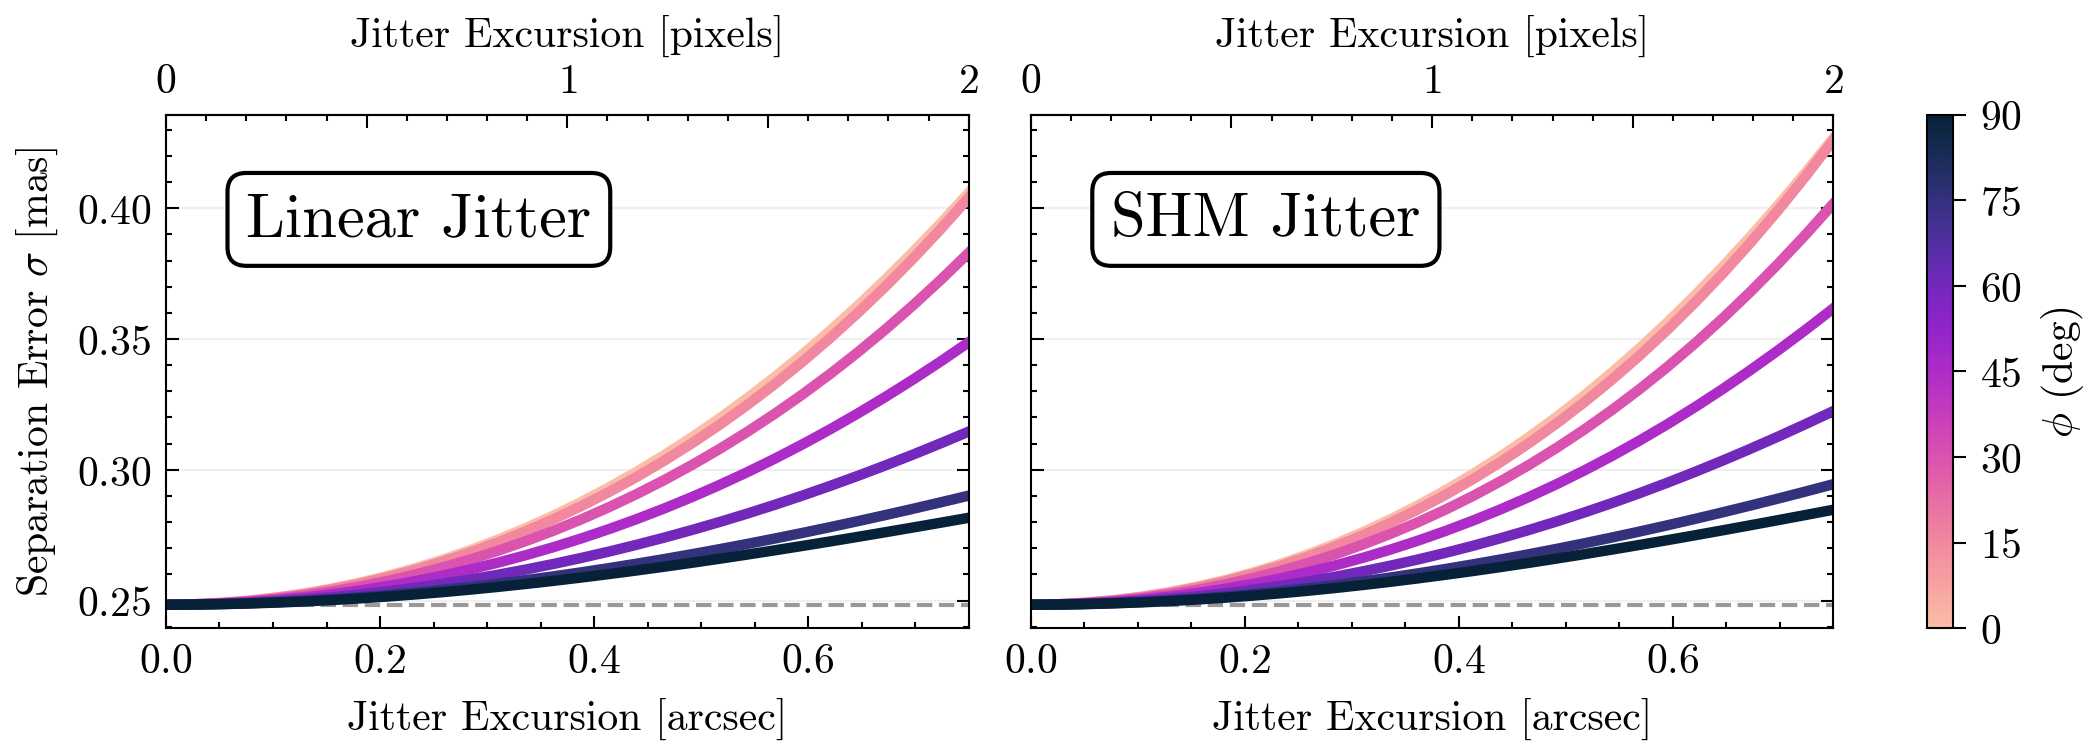

In [10]:
det_pscale = 0.375
mags = test_mags
angs = test_angs
colors = ito_seven
baseline = 0.24839681897145435  # mas

cmap = mpl.colormaps["cmr.bubblegum_r"]
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=90))
colors = cmap(angs / 90)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(7, 2.5), sharey=True, layout="compressed")

# looping over jitter type
for i, seps in enumerate([seps_lin, seps_shm]):

    # baseline
    if baseline is not None:
        ax[i].axhline(
            baseline, linestyle="--", c="k", alpha=0.4, label="No Jitter", linewidth=1
        )

    # looping over each line
    for sep, ang, c in zip(seps.T, angs, colors):
        ax[i].plot(
            mags,
            1000 * sep,
            label=r"$\phi\,=\,$" + f"{ang:.0f}",
            color=c,
            linewidth=2.5,
        )

    ax[i].tick_params(axis="x", which="both", top=False)

    # Add secondary x-axis scale showing units of pixels
    ax2 = ax[i].secondary_xaxis(
        "top", functions=(lambda x: x / det_pscale, lambda x: x * det_pscale)
    )
    ax2.set_xticks([0.0, 1.0, 2.0])  # Custom major xticks
    ax2.set_xticklabels([r"$0$", r"$1$", r"$2$"])  # Custom labels for major ticks
    ax2.minorticks_on()  # Enable minor ticks
    ax2.xaxis.set_minor_locator(
        mpl.ticker.AutoMinorLocator(5)
    )  # 5 minor ticks between major ticks

    ax2.set(xlabel="Jitter Excursion [pixels]", xticks=[0, 0.5, 1.0, 1.5, 2.0])
    ax[i].grid(True, alpha=0.2, linestyle="-", axis="y")

ax[0].set(
    xlabel="Jitter Excursion [arcsec]",
    ylabel=r"Separation Error $\sigma$ [mas]",
    xlim=(0, mags.max()),
)
ax[1].set(
    xlabel="Jitter Excursion [arcsec]",
    xlim=(0, mags.max()),
)

# adding text
for i, title in enumerate(["Linear Jitter", "SHM Jitter"]):
    ax[i].text(
        0.1,
        0.85,
        title,
        size=15,
        transform=ax[i].transAxes,
        ha="left",
        va="top",
        bbox=dict(
            facecolor="white",
            edgecolor="black",
            boxstyle="round,pad=0.3",
        ),
    )

cbar = fig.colorbar(sm, ax=ax, ticks=angs, label=r"$\phi$ (deg)")
cbar.ax.tick_params(direction="out")
cbar.ax.minorticks_off()

plt.savefig("files/paper_figs/lin_shm_sweep.pdf", bbox_inches="tight", dpi=500)
plt.show()

## Multivariate Normal Model: FIA

The Fisher Information analysis for the multivariate normal jitter model, and its respective plot.

In [11]:
def fwhm_to_det(fwhm, shear):
    return (1 - shear) ** 2 * (fwhm / 2.35482) ** 4


def det_to_fwhm(det, shear):
    return 2.35482 * (det / (1 - shear) ** 2) ** 0.25


def powspace(start, stop, power, num):
    """
    To generate r values at appropriate intervals.
    """
    start = np.power(start, 1 / float(power))
    stop = np.power(stop, 1 / float(power))
    return np.power(np.linspace(start, stop, num=num), power)

In [12]:
# Marginal params for normal model
norm_params = [
    "separation",
    "position_angle",
    "x_position",
    "y_position",
    "log_flux",
    "contrast",
    "Jitter.r",
    "Jitter.shear",
    "Jitter.phi",
    "aperture.coefficients",
    # 'wavelengths',
    # 'psf_pixel_scale',
]

det_pscale = models["norm"].psf_pixel_scale
oversample = models["norm"].oversample
kernel_size = models["norm"].Jitter.kernel_size

phis = np.linspace(0, 90, 7)
shears = np.array([0, 0.3, 0.7])
rs = powspace(1e-7, fwhm_to_det(1.01 * det_pscale, shears[0]), 2, 30)

In [13]:
if run_compute:

    seps = []
    fwhms = []
    kernels = []

    for shear_idx, shear in enumerate(shears):
        model = models["norm"].set("detector.Jitter.shear", shear)

        for r_idx, r in tqdm(enumerate(rs), total=len(rs)):
            fwhm = det_to_fwhm(r, shear)
            fwhms.append(fwhm)
            model = model.set("detector.Jitter.r", r)

            for phi_idx, phi in enumerate(phis):

                # skipping over different angles for shear = 0 as symmetric
                if shear_idx == 0 and phi_idx != 0:
                    sep = np.nan

                else:
                    model = model.set("detector.Jitter.phi", phi)
                    data = model.model()

                    cov = cov_fns["norm"](model, np.round(data), norm_params)
                    sep = np.sqrt(np.abs(cov[0, 0]))
                    if phi_idx == 0:
                        if r == rs.max():
                            kernels.append(
                                model.Jitter.generate_kernel(det_pscale / oversample)
                            )

                seps.append(sep)

    seps = np.array(seps).reshape(len(shears), len(rs), len(phis))
    fwhms = np.array(fwhms).reshape(len(shears), len(rs))

    # saving
    np.save("files/seps/seps_norm.npy", seps)
    np.save("files/seps/kernels.npy", kernels)
    np.save("files/seps/fwhms.npy", fwhms)

In [14]:
seps_norm = np.load("files/seps/seps_norm.npy")
kernels = np.load("files/seps/kernels.npy")
fwhms = np.load("files/seps/fwhms.npy")

findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.
findfont: Font family 'Georgia' not found.


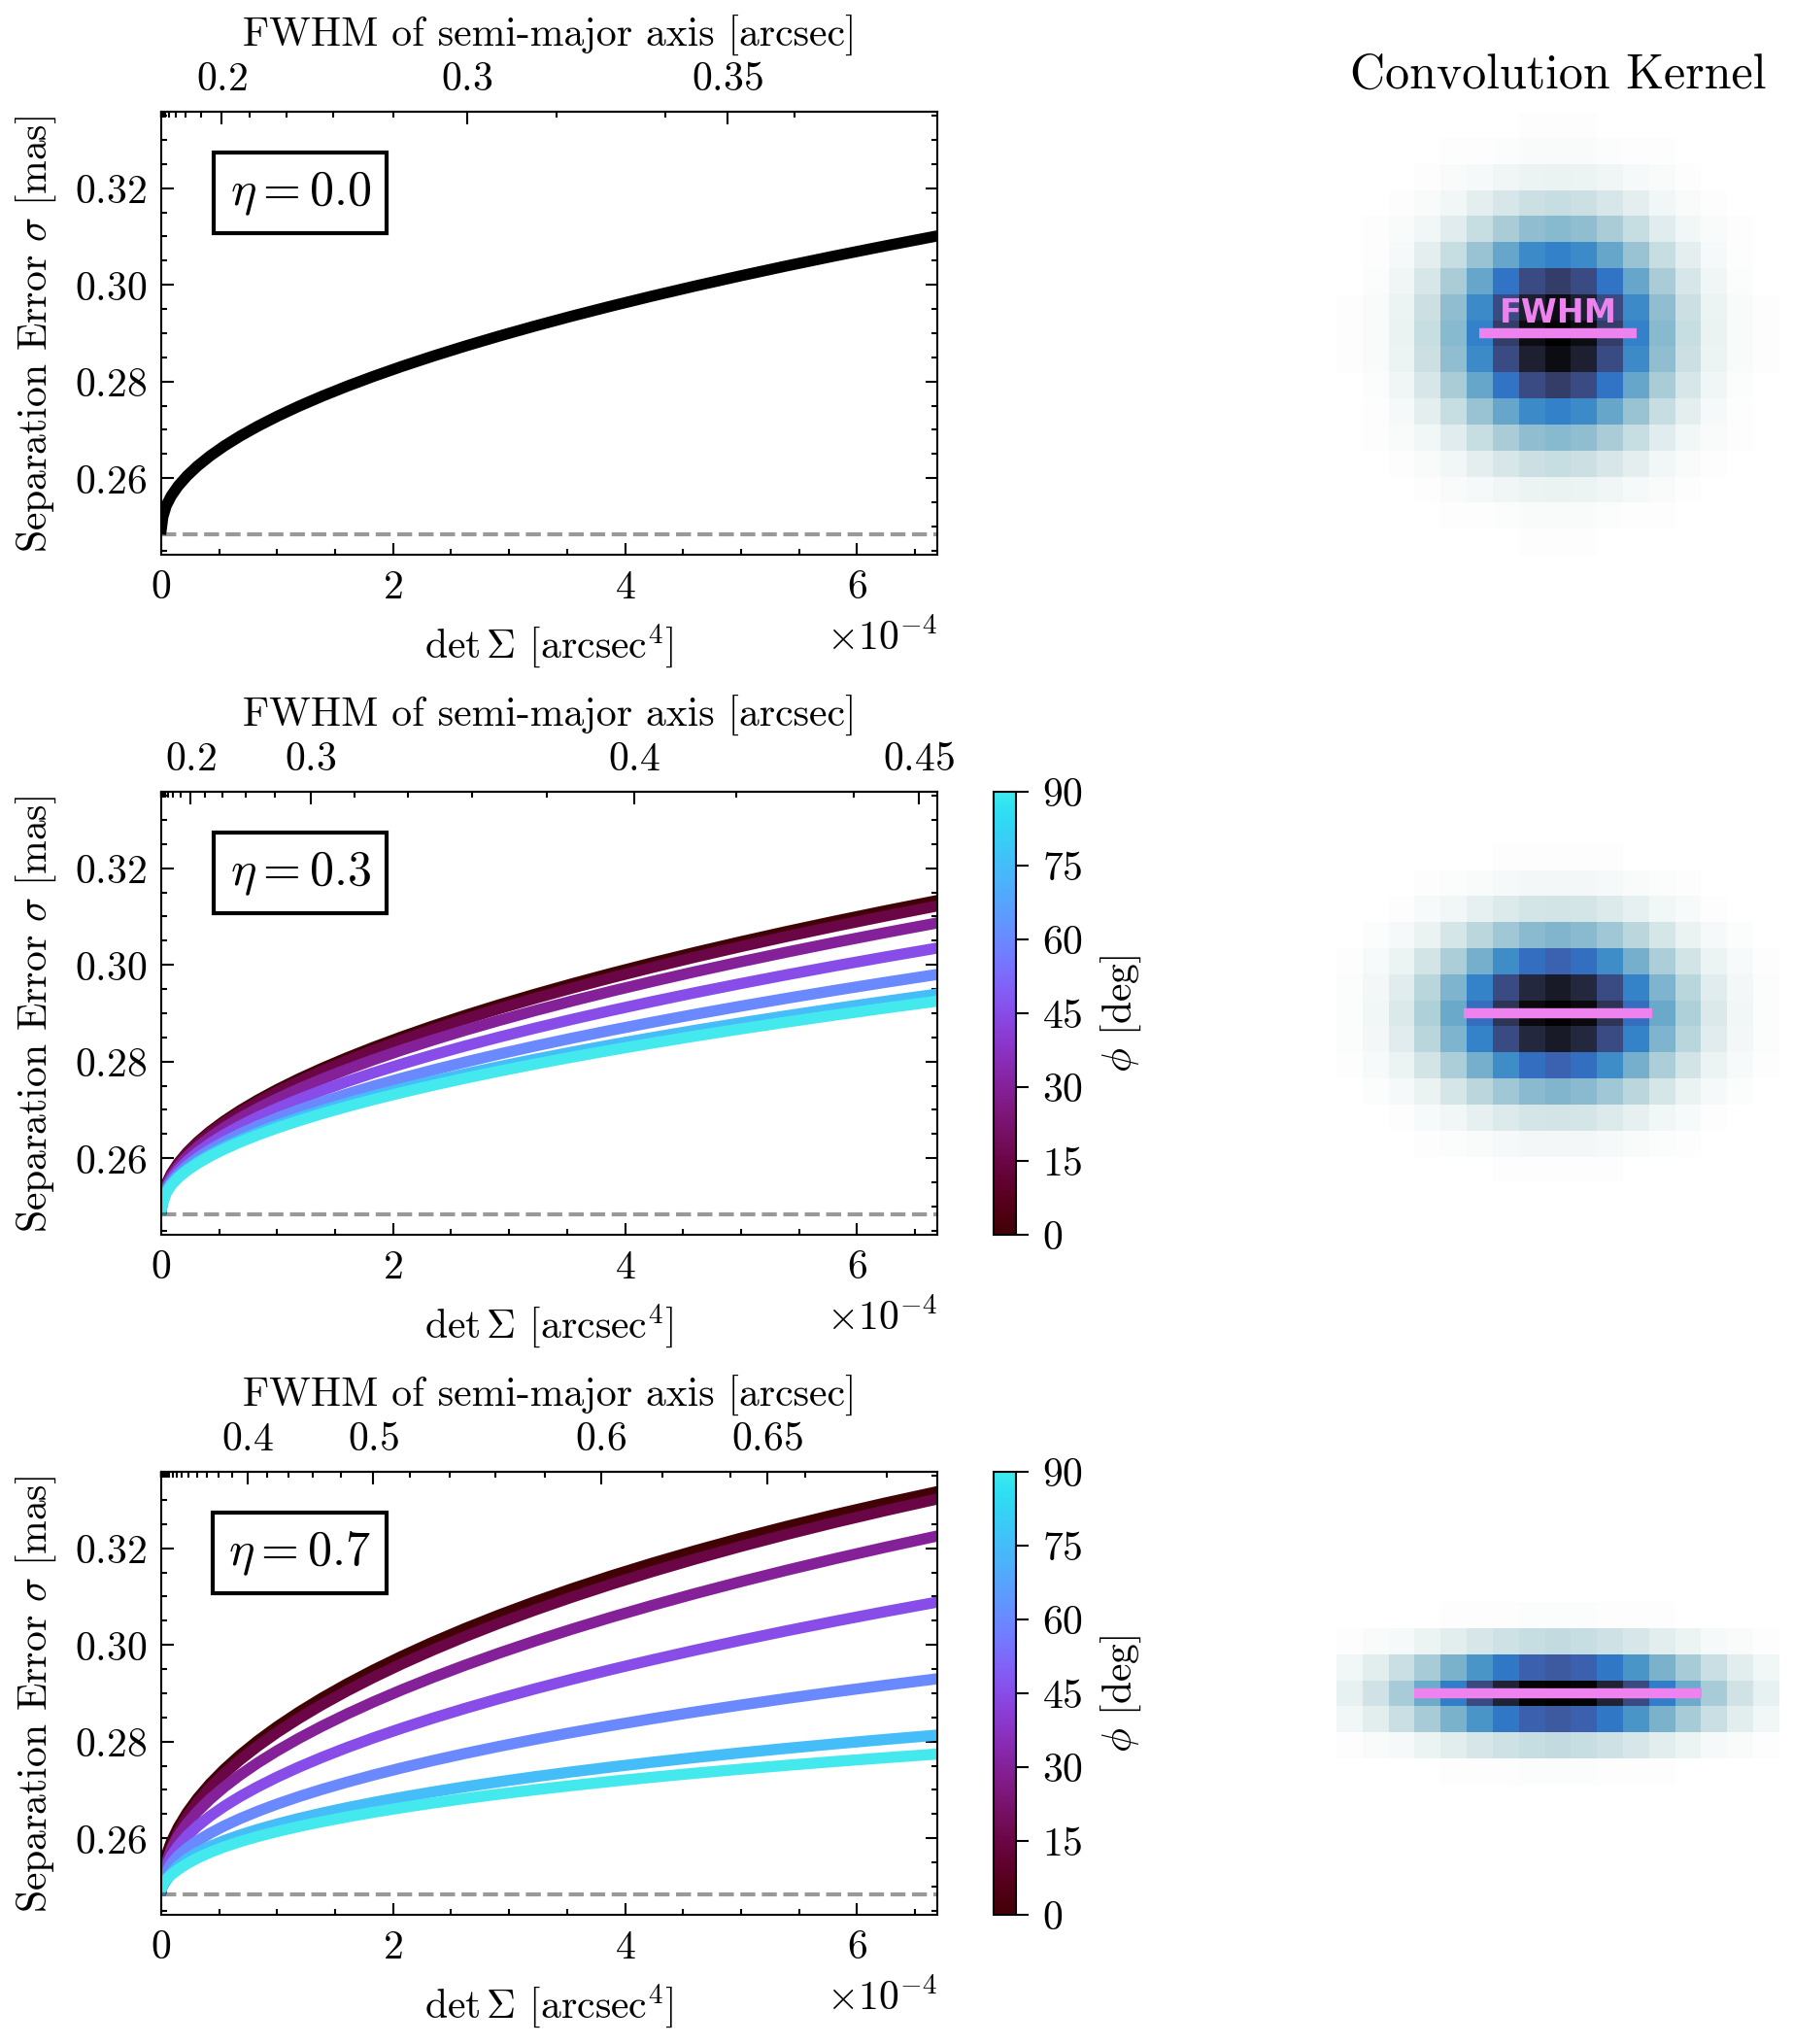

In [15]:
# baseline = 0.24839681897145435  # previously calculated

cmap = mpl.colormaps["cmr.gem"]
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=90))
colors = cmap(phis / 90)

fig, axes = plt.subplots(
    len(shears), 2, figsize=(9, 7), sharey="col", layout="compressed"
)

for i, shear in enumerate(shears):
    ax, axe = axes[i]
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 2))
    ax.tick_params(axis="x", which="both", top=False)

    for sep, phi, c in zip(seps_norm[i].T, phis, colors):
        if shear == 0:
            label = None
            c = "k"
        else:
            label = label = r"$\phi\,=$" + f" {phi:.0f}"
        ax.plot(rs, 1000 * sep, label=label, color=c, marker=None, linewidth=2.75)
    ax.set(
        xlabel=r"det$\,\Sigma$ [arcsec$^{4}$]",
        ylabel=r"Separation Error $\sigma$ [mas]",
        # ylim=(baseline - 0.01, 0.8),
        xlim=(0, rs.max()),
    )

    ax.text(
        0.27,
        0.87,
        rf"$\eta={shear}$",
        size=12,
        transform=ax.transAxes,
        ha="right",
        va="top",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle=None),
    )
    ax.axhline(
        baseline, linestyle="--", c="k", alpha=0.4, label="No Jitter", linewidth=1
    )

    if shear == 0:
        cbar = fig.colorbar(sm, ax=ax)
        cbar.ax.set_visible(False)  # Hide the colorbar visually
    else:
        cbar = fig.colorbar(sm, ax=ax, ticks=angs, label=r"$\phi$ [deg]")
        cbar.ax.minorticks_off()  # Ensure minor ticks are disabled
        cbar.ax.tick_params(direction="out")

    extent = (
        np.array([-kernel_size / 2, kernel_size / 2, -kernel_size / 2, kernel_size / 2])
        * det_pscale
        / oversample
    )
    c = axe.imshow(
        kernels[i],
        cmap="cmr.arctic_r",
        origin="lower",
        extent=extent,
    )
    axe.set(
        xticks=[],
        yticks=[],
    )
    axe.minorticks_off()

    max_fwhm = det_to_fwhm(rs.max(), shear)
    axe.hlines(
        0,
        -max_fwhm / 2,
        max_fwhm / 2,
        colors="violet",
        linestyles="solid",
        label="FWHM",
        linewidth=2.5,
    )

    for spine in ["top", "right", "left", "bottom"]:
        axe.spines[spine].set_visible(False)

    if shear == 0:
        axe.set_title("Convolution Kernel")
        axe.text(
            0.0,
            0.05,
            "FWHM",
            size=8,
            ha="center",
            va="center",
            c="violet",
            weight="bold",
            fontname="Georgia",
        )


# SECONDARY AXES (was buggy so had to remove from loop)

# First subplot
ax00 = axes[0][0].secondary_xaxis(
    "top",
    functions=(
        lambda r: det_to_fwhm(r, shears[0]),
        lambda fwhm: fwhm_to_det(fwhm, shears[0]),
    ),
)
ax00.set_xticks([0.2, 0.3, 0.35])  # Custom major xticks
ax00.set_xticklabels([r"$0.2$", r"$0.3$", r"$0.35$"])  # Custom labels for major ticks
ax00.minorticks_on()  # Enable minor ticks
ax00.xaxis.set_minor_locator(
    mpl.ticker.AutoMinorLocator(5)
)  # 5 minor ticks between major ticks
ax00.set_xlabel("FWHM of semi-major axis [arcsec]")

# Second subplot
ax11 = axes[1][0].secondary_xaxis(
    "top",
    functions=(
        lambda r: det_to_fwhm(r, shears[1]),
        lambda fwhm: fwhm_to_det(fwhm, shears[1]),
    ),
)
ax11.set_xticks([0.2, 0.3, 0.4, 0.45])  # Custom major xticks
ax11.set_xticklabels(
    [r"$0.2$", r"$0.3$", r"$0.4$", r"$0.45$"]
)  # Custom labels for major ticks
ax11.minorticks_on()  # Enable minor ticks
ax11.xaxis.set_minor_locator(
    mpl.ticker.AutoMinorLocator(5)
)  # 5 minor ticks between major ticks
ax11.set_xlabel("FWHM of semi-major axis [arcsec]")

# First subplot
ax22 = axes[2][0].secondary_xaxis(
    "top",
    functions=(
        lambda r: det_to_fwhm(r, shears[2]),
        lambda fwhm: fwhm_to_det(fwhm, shears[2]),
    ),
)
ax22.set_xticks([0.4, 0.5, 0.6, 0.65])  # Custom major xticks
ax22.set_xticklabels(
    [r"$0.4$", r"$0.5$", r"$0.6$", r"$0.65$"]
)  # Custom labels for major ticks
ax22.minorticks_on()  # Enable minor ticks
ax22.xaxis.set_minor_locator(
    mpl.ticker.AutoMinorLocator(5)
)  # 5 minor ticks between major ticks
ax22.set_xlabel("FWHM of semi-major axis [arcsec]")

plt.savefig("files/paper_figs/norm_sweep.pdf", bbox_inches="tight", dpi=500)
plt.show()

## Model Cross-Fitting

The code for model cross-fitting to investigate systematic model-introduced bias and a potential increase in separation error.

In [16]:
def run_grad_desc(
    model,
    data,
    params,
    optimisers: dict,
    loss_func,
    iters=100,
    plot=False,
    verbose=True,
    eps=3e-4,  # termination condition
):
    """
    Run gradient descent on a model.
    """

    # run gradient descent
    optim, opt_state = zdx.get_optimiser(model, params, optimisers)
    losses, models_out = [], []

    if verbose:
        t = tqdm(range(iters), desc="Gradient Descent")
    else:
        t = range(iters)

    for i in t:

        # for termination condition
        last_params = model.get(params)

        loss, grads = loss_func(model, np.round(data))

        # print(grads)

        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)

        models_out.append(model)
        losses.append(loss)

        if verbose:
            t.set_description("Loss: {:.6e}".format(loss))  # update the progress bar

        # Termination condition
        new_params = model.get(params)  # getting new parameters
        scaled_diffs = jax.tree.map(
            lambda x, y: np.abs((x - y) / y),
            last_params,
            new_params,
        )
        if eps is not None and i > 5:
            if np.all(
                np.array(  # if all parameters have converged
                    jax.tree.map(lambda x: np.all(x < eps), scaled_diffs)
                )
            ):
                print("Converged early")
                break

    if plot:
        plt.figure()
        plt.title("Log Poisson Loss")
        plt.xlabel("Epoch")
        plt.plot(range(i + 1), losses)
        plt.show()

        plt.figure()
        for param in params:
            param_out = np.array([m.get(param) for m in models_out])
            if param_out.size // iters > 1:
                plt.plot(range(i + 1), param_out - param_out[0], label=param)
            else:
                plt.plot(range(i + 1), param_out, label=param)
            plt.xlabel("Epoch")
            plt.legend()
            plt.ticklabel_format(style="plain", axis="both", useOffset=False)
            plt.show()

    return models_out[-1]

In [17]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e100}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e100, shed_dict)


base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)
base_adam = lambda vals: optax.adam(vals)

sgd = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))
adam = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))

In [18]:
sep_dict_save_dir = "files/sep_dicts/"

if run_compute:
    sep_dict = {}
    n_realisations = 500

    # Gradient descent
    common_optimisers = {
        "separation": sgd(1e-8, 0),
        "position_angle": sgd(3e-7, 3),
        "x_position": sgd(3e-9, 0),
        "y_position": sgd(3e-9, 2),
        "log_flux": sgd(2e-9, 0),
        "contrast": sgd(1e-6, 1),
        "aperture.coefficients": sgd(2e-4, 0),
    }

    lin_opts = {
        "jitter_mag": sgd(2e-7, 0),
        "jitter_angle": sgd(5e-2, 0),
    }

    norm_opts = {
        "Jitter.r": sgd(5e-14, 30),
        "Jitter.shear": sgd(4e-5, 0),
        "Jitter.phi": sgd(1e0, 0),
    }

    # looping over models
    for model_key in tqdm(models.keys(), desc="Models"):

        if model_key == "norm":
            optimisers = {**common_optimisers, **norm_opts}
        else:
            optimisers = {**common_optimisers, **lin_opts}

        model = models[model_key]
        loglike_fn = loglike_fns[model_key]

        @zdx.filter_jit
        @zdx.filter_value_and_grad(list(optimisers.keys()))
        def loss_func(model, data):
            return -loglike_fn(model, data)

        # looping over data arrays
        for data_key in tqdm(datas.keys(), desc="Data Arrays"):
            data = datas[data_key]
            sep_values = np.array([], dtype=np.float64)

            if model_key == "norm":
                continue

            # looping over noise realisations
            for i in tqdm(range(n_realisations), desc="Noise Realisations"):

                noisy_data = jr.poisson(
                    jr.PRNGKey(random.randint(0, int(1e8))),
                    data,
                )

                # RUN GRAD DESCENT
                gd_model = run_grad_desc(
                    model,
                    noisy_data,
                    list(optimisers.keys()),
                    optimisers=list(optimisers.values()),
                    iters=100,
                    loss_func=loss_func,
                    eps=1e-5,
                    plot=False,
                )

                sep_values = np.append(sep_values, gd_model.separation)
            sep_dict[f"{model_key}_{data_key}"] = sep_values

    # saving
    current_time = datetime.now().strftime("%d-%m-%Y_%H-%M")
    save_str = current_time + f"_{n_realisations:04d}.npy"
    np.save(os.path.join(sep_dict_save_dir, save_str), sep_dict)

In [19]:
total_sep_dict = {}
sep_dict_save_dir = "files/sep_dicts/"

# looping over saved sep_dicts
for f in os.listdir(sep_dict_save_dir):
    if not f.endswith(".npy"):
        continue

    # loading each file
    this_dict = np.load(os.path.join(sep_dict_save_dir, f), allow_pickle=True).item()

    # appending to total_sep_dict
    for k in this_dict.keys():
        total_sep_dict[k] = (
            np.append(total_sep_dict[k], this_dict[k])
            if k in total_sep_dict.keys()
            else this_dict[k]
        )

In [20]:
import numpy as onp


def bootstrap_histogram(histogram: Array, num_bootstraps: int) -> Array:
    """
    Perform bootstrapping on a histogram to get theuncertainty in the mean and standard deviation.
    """
    boot_means = []
    boot_stds = []

    for _ in range(num_bootstraps):
        resampled_data = onp.random.choice(
            histogram,
            size=len(histogram),
            replace=True,
        )
        boot_means.append(np.mean(resampled_data))
        boot_stds.append(np.std(resampled_data, ddof=1))

    # Compute statistics
    mean_estimate = np.mean(histogram)
    std_estimate = np.std(histogram)
    mean_uncertainty = np.std(np.array(boot_means))
    std_uncertainty = np.std(np.array(boot_stds))

    return mean_estimate, mean_uncertainty, std_estimate, std_uncertainty

3000 noise realisations.


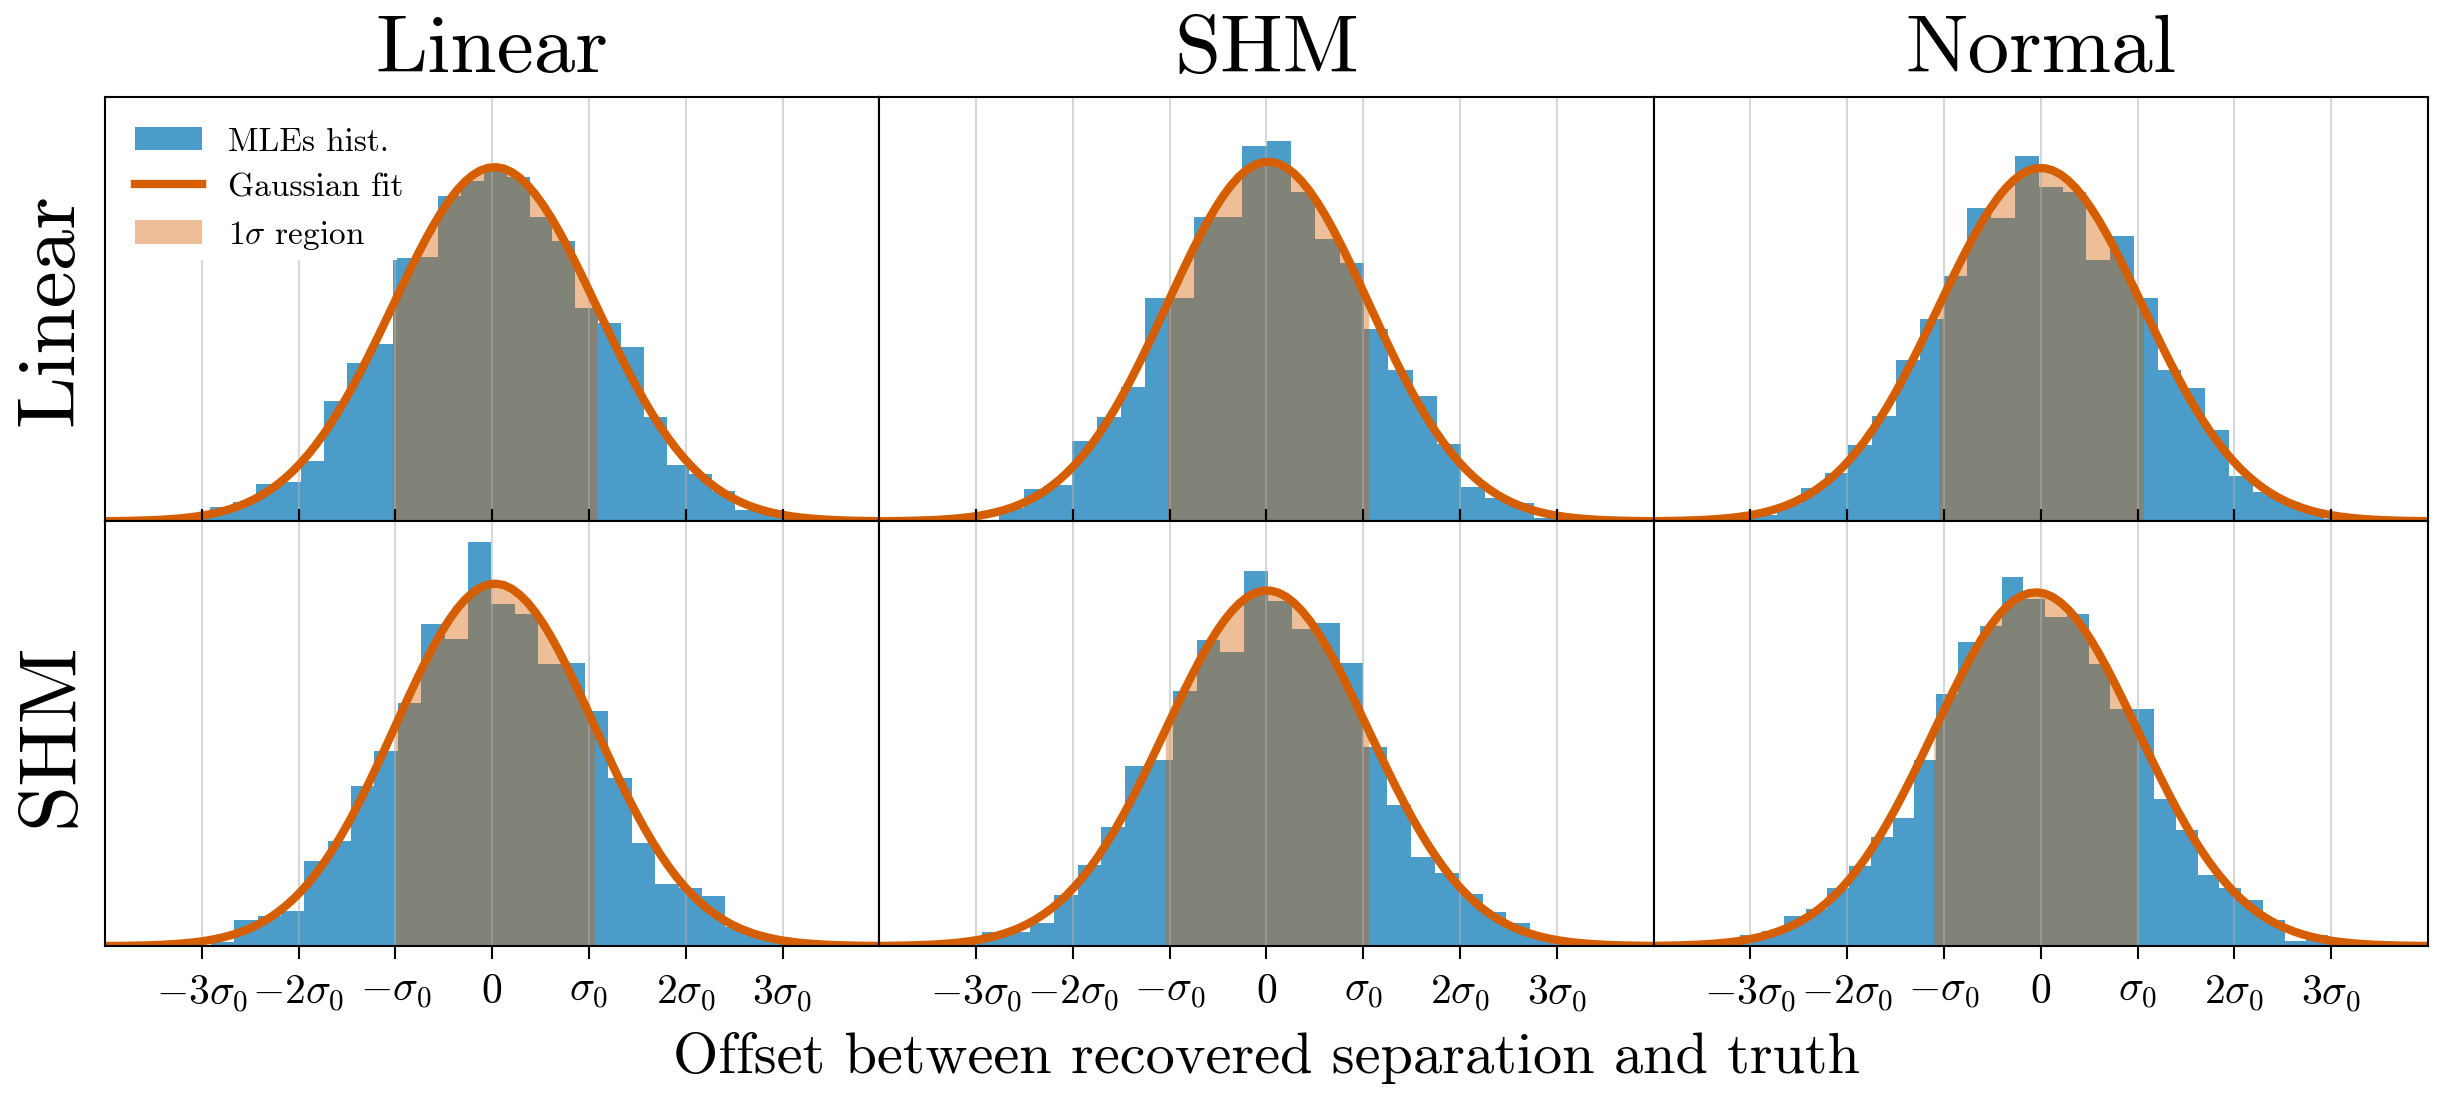

In [21]:
print(f"{len(list(total_sep_dict.values())[0])} noise realisations.")

n_bins = 30
true_sep = models["lin"].separation  # arcseconds
fontsize = 20
fisher_sigmas = {
    "lin": 1e-3 * 0.24839681897145435,
    "shm": 1e-3 * 0.24839681897145435,
}  # pre-calculated
titles = {"lin": "Linear", "shm": "SHM", "norm": "Normal"}


fig, ax = plt.subplots(
    2,
    3,
    figsize=(8.5, 3.5),
    sharex=True,
    sharey=True,
)
fig.subplots_adjust(
    top=0.915,
    bottom=0.106,
    left=0.074,
    right=0.985,
    hspace=0.0,
    wspace=0.0,
)

for i in range(2):
    for j in range(3):
        if i == 0:
            sigma_0 = fisher_sigmas["lin"]
        elif i == 1:
            sigma_0 = fisher_sigmas["shm"]

        key = f"{list(models.keys())[i]}_{list(datas.keys())[j]}"
        results = total_sep_dict[key]
        offset_hist = results - true_sep  # in arseconds
        offset_hist /= sigma_0  # converting to sigma units

        ax[i][j].hist(
            offset_hist,
            bins=n_bins,
            density=True,
            color=ito_seven[0],
            alpha=0.7,
            histtype="stepfilled",
            label="MLEs hist.",
        )
        ax[i][j].set(
            # title=f"{key}",
            xlim=(-4, 4),
            xticks=range(-3, 4),
            yticks=[],
        )

        ax[i][j].set_xticklabels(
            [
                r"$-3\sigma_0$",
                r"$-2\sigma_0$",
                r"$-\sigma_0$",
                "0",
                r"$\sigma_0$",
                r"$2\sigma_0$",
                r"$3\sigma_0$",
            ]
        )

        ax[i][j].minorticks_off()
        ax[i][j].tick_params(direction="out")
        ax[i][j].grid(True, alpha=0.5, linestyle="-")

        # # Bootstrapping to find mean, std and uncertainties of each
        # mu, dmu, std, dstd = bootstrap_histogram(offset_hist, 1000)

        # if we don't care about the uncertainties
        mu = np.mean(offset_hist)
        std = np.std(offset_hist)

        xmin, xmax = plt.xlim()

        xs = np.linspace(xmin, xmax, 100)
        bell_curve = jax.scipy.stats.norm.pdf(xs, mu, std)

        one_sigma_xs = np.linspace(mu - std, mu + std, 100)
        one_sigma_bell = jax.scipy.stats.norm.pdf(one_sigma_xs, mu, std)

        mean_max = jax.scipy.stats.norm.pdf(mu, mu, std)

        # Plot the normal distribution curve
        ax[i][j].plot(
            xs, bell_curve, ito_seven[1], linewidth=2, alpha=1.0, label="Gaussian fit"
        )
        ax[i][j].fill_between(
            one_sigma_xs,
            one_sigma_bell,
            color=ito_seven[1],
            alpha=0.4,
            zorder=1,
            label=r"$1\sigma$ region",
            linewidth=0,
        )

        if j != 1:
            ax[i][j].set_xlabel(None)
        else:
            ax[i][j].set_xlabel(
                r"Offset between recovered separation and truth",
                fontsize=0.7 * fontsize,
            )

        if j == 0:
            ax[i][j].set_ylabel(f"{titles[list(models.keys())[i]]}", fontsize=fontsize)

            if i == 0:
                legend = ax[i][i].legend(
                    fontsize=8, facecolor="white", loc="upper left"
                )

                # # This is just to create a blank space behind the legend
                rect = mpl.patches.Rectangle(
                    (0.02, 0.62),
                    0.355,
                    0.4,
                    fill=True,
                    edgecolor=None,
                    transform=ax[i][j].transAxes,
                    zorder=2,
                    color="white",
                )

                ax[i][j].add_patch(rect)

        else:
            ax[i][j].set(
                ylabel=None,
            )
        if i == 0:
            ax[i][j].set(
                xlabel=None,
            )
            ax[i][j].set_title(
                f"{titles[list(datas.keys())[j]]}", fontsize=fontsize
            )  # Set the text size of the title
            ax[i][j].tick_params(axis="x", which="both", top=False, direction="in")
        else:
            ax[i][j].set(
                title=None,
            )

plt.savefig("files/paper_figs/biases.pdf", dpi=500)
plt.show()